# Chapter 5: Functions?!
Boy howdy, do I love functions. Eat your heart out Java!!!

## 30: Know that Function Arguments can be Mutated
Python aint got them fancy pointer doodads, but that doesn't mean you're always safe passing things around.

In [10]:
def mutant_attack(items):
    items.append(4) # mutate what the reference points at

x = [1,2,3]
mutant_attack(x)
x

[1, 2, 3, 4]

In [8]:
def replace_em(items):
    items = [9,8,7] # trying to mutate the reference itself

y = [1,2,3]
replace_em(y)
y

[1, 2, 3]

In [11]:
z = x
mutant_attack(z)
z

[1, 2, 3, 4, 4]

### Bonus pop quiz for the Java-striken:
Does Java do this too?

In [19]:
class MyClass:
    def __init__(self,value):
        self.value = value

x = MyClass(10)


def my_mutator(obj):
    obj.value = 20

my_mutator(x)

x.value

20

## 31: Return Dedicated Result Objects Instead of Requiring Function Callers to Unpack More Than Three Variables
Lets take a look at a meaty function:

In [24]:
from statistics import median as built_in_median

def gimme_stats(nums):
    minimum = min(nums)
    maximum = max(nums)
    count = len(nums)
    average = sum(nums) / count
    median = built_in_median(nums)
    return minimum, maximum, average, median, count

minimum, maximum, average, median, count = gimme_stats([1,2,3,4,5]) # lame
gimme_stats([1,2,3,4,5]) 

(1, 5, 3.0, 3, 5)

This sucks. What happens if you got things in the wrong order, or had the wrong number of unpacking vars? BOO

Dataclasses to the rescue!
Eric shameless brag moment, after reading the title of this item I thought "oh yeah definitely use a dataclass"

(almost as if someone has read the previous edition of this book 🤔)

In [26]:
@dataclass
class Stats:
    minimum: float
    maximum: float
    average: float
    median: float
    count: int

def gimme_stats(nums):
    return Stats(
        minimum=min(nums),
        maximum=max(nums),
        count=len(nums),
        average=sum(nums) / count,
        median=built_in_median(nums),
    )

those_stats = gimme_stats([1,2,3,4,5,6,7,8,9])
those_stats

Stats(minimum=1, maximum=9, average=9.0, median=5, count=9)

This is easier to work with, and lets you fetch things by their names too like `those_stats.average` etc

## 32: Prefer Raising Exceptions to Returning `None`
Whoops, Eric did this in a few spots in `swordfish`! Loser.

#### For the Java-Afflicted
Returning `None` is basically as egregious as returning `null`. There's no reason to do it in modern Java.

In [31]:
# A seemingly reasonable case
def careful_divide(a, b):
    try:
        return a / b
    except ZeroDivisionError:
        return None

x, y = 1, 0
result = careful_divide(x, y)
if result is None:
    print("dang it, we divided by zero!!!")

dang it, we divided by zero!!!


In [32]:
# Where it gets a bit messy:
x, y = 0, 5
result = careful_divide(x, y)
if not result:
    print("Uhh.... wait this wasn't a None")

Uhh.... wait this wasn't a None


In [35]:
# You could do it like this, as the book explains
def careful_divide_bad_no(a, b):
    try:
        return True, a / b
    except ZeroDivisionError:
        return False, None

# But lets be real, this is bad API design. We foist extra work on callers,
# and there's no guarantee they'll heed it anyway..
# they might even think the first value is the result. It's bad! BOO

_, result = careful_divide_bad_no(x, y)
if not result:
    print("Invalid inputs")

Invalid inputs


In [36]:
# In Python, exceptions aren't always _exceptional_

def careful_divide(a, b):
    try:
        return a / b
    except ZeroDivisionError:
        raise ValueError("Invalid inputs")

x, y = 5, 2
try:
    result = careful_divide(x, y)
except ValueError:
    print("Invalid inputs")
else:
    print(f"Result is {result:.1f}")


Result is 2.5


This is kind of a trite example, because honestly we could always just _not_ catch/handle the `ZeroDivisionError` in the function and put that onus on the caller.

A better way to think about this would be with an API and a Database:

In [38]:
class MyDbClient:
    """A really bad DB client."""
    def connect(self):
        raise ValueError("I REFUSE to connect, you CANNOT make me!")

my_trustworthy_db_client = MyDbClient()

db_connection = my_trustworthy_db_client.connect()

ValueError: I REFUSE to connect, you CANNOT make me!

In [50]:
class MyHttpException(Exception):
    """An error your webserver knows how to handle."""
    def __init__(self, message, error_code):
        super().__init__(message)
        self.error_code = error_code

def my_get_route():
    """Gets the item from the database.

    Raises:
        MyHttpException: When the database is being goofy.
    """
    try:
        db_connection = my_trustworthy_db_client.connect()
    except ValueError as e:
        raise MyHttpException("Something goofed.", 500) from e

# my_get_route()

PAUSE: what's `from e`?

In [51]:
def my_top_handler():
    try:
        return my_get_route()
    except MyHttpException as e:
        return e.error_code

my_top_handler()

500

# 33: Know How Closures Interact with Variable Scope and `nonlocal`

In [57]:
def sort_notifications(values, group):
    def sort_key(x): # define our sort key as a closure function
        if x in group:
            return (0, x) # rely on built-in sequence comparison behavior
        return (1, x)

    values.sort(key=sort_key)

# imagine these are notification IDs
notifications = [8, 3, 1, 2, 5, 4, 7, 6]
high_priority = {2, 3, 5, 7}
sort_notifications(notifications, high_priority)
notifications

# for each notification send to front end blah blah

[2, 3, 5, 7, 1, 4, 6, 8]

Oops, new requirements: the FE team would like to _know_ if any of the high priority notifications were seen or not.

In [1]:
def sort_notifications2(values, group):
    found = False
    
    def sort_key(x):
        if x in group:
            found = True # we found one!!!
            return (0, x)
        return (1, x)

    values.sort(key=sort_key)
    return found

notifications = [8, 3, 1, 2, 5, 4, 7, 6]
high_priority = {2, 3, 5, 7}
found = sort_notifications2(notifications, high_priority)
print(f"Found: {found}; order: {notifications}")

Found: False; order: [2, 3, 5, 7, 1, 4, 6, 8]


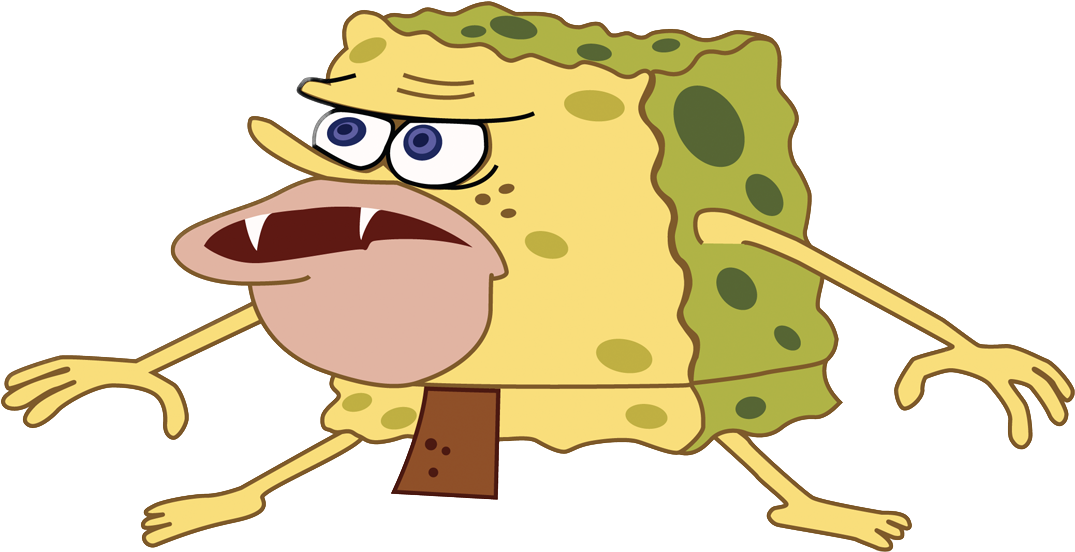

### Okay, so what the hell?
The `found = True` is treated as _variable assignment_ by the Python interpreter. Essentially, it traversed the scope and immediately found `found = True` which is a valid variable assignment, so it stopped here, and determined this expression was creating a new variable `found` in the local scope. It never traversed back up to see the `found = False`

This is intentional behavior, to keep the global module scope clean.

In [3]:
def sort_notifications2(values, group):
    found = False
    
    def sort_key(x):
        nonlocal found  # give Python a lil hint...
        if x in group:
            found = True
            return (0, x)
        return (1, x)

    values.sort(key=sort_key)
    return found

notifications = [8, 3, 1, 2, 5, 4, 7, 6]
high_priority = {2, 3, 5, 7}
found = sort_notifications2(notifications, high_priority)
print(f"Found: {found}; order: {notifications}")

Found: True; order: [2, 3, 5, 7, 1, 4, 6, 8]
